In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import mplhep as hep
import tables as tb
from pathlib import Path
from vdmtools.io import hd5_to_pandas
from tqdm import tqdm
import json
import datetime
hep.style.use("CMS")

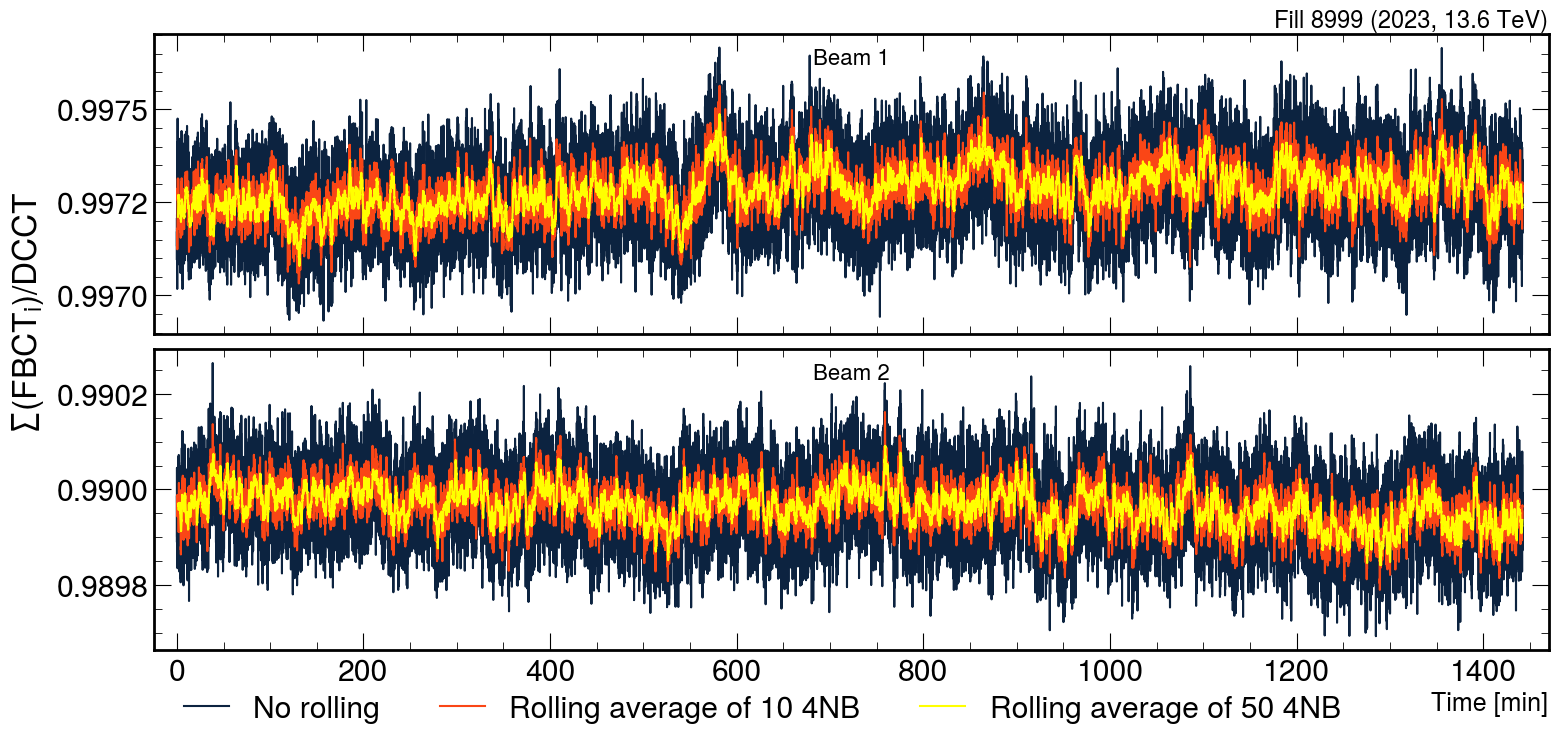

In [4]:
handle = tb.open_file("/home/fabiocfabini/Work/BRIL/brildata/23/8999/8999_369802_2306281945_2306292018.hd5")
beam = handle.get_node("/beam")

timestamps = []
current_calibration_b1 = []
current_calibration_b2 = []
for row in tqdm(beam.where(condition="status == b'STABLE BEAMS'"), total=60720):
    timestamps.append(row["timestampsec"])
    # current_calibration_b1.append((row["bxintensity1"] * row["collidable"]).sum() / row["intensity1"])
    # current_calibration_b2.append((row["bxintensity2"] * row["collidable"]).sum() / row["intensity2"])
    current_calibration_b1.append((row["bxintensity1"]*0.993).sum() / row["intensity1"])
    current_calibration_b2.append((row["bxintensity2"]*0.993).sum() / row["intensity2"])
handle.close()

ignore_last = 79

data = pd.DataFrame({
    "time": (np.array(timestamps) - timestamps[0]) / 60,
    # "time": pd.to_datetime(timestamps, unit="s") + datetime.timedelta(hours=2),
    "calib_b1": current_calibration_b1,
    "calib_b2": current_calibration_b2,
})

fig, axs = plt.subplots(2, 1, figsize=(18,8), sharex=True)
fig.subplots_adjust(hspace=0.05)


colors = ["#0c2340", "#fa4616", "yellow"]
xfmt = mdates.DateFormatter('%H:%M')
hours = mdates.HourLocator(interval=4)
yfmt = mticker.FormatStrFormatter(fmt="%.4f")
for i, ax in enumerate(axs.flatten()):
    # ax.xaxis.set_major_formatter(xfmt)
    # ax.xaxis.set_major_locator(hours)
    ax.yaxis.set_major_formatter(yfmt)

    for j, span in enumerate([1, 10, 50]):
        label = "No rolling" if span == 1 else f"Rolling average of {span} 4NB"
        ax.plot(data["time"].iloc[:-ignore_last], data[f"calib_b{i+1}"].rolling(span).mean().iloc[:-ignore_last], label=label, color=colors[j])

axs[0].text(-0.09, 0.75, "$\sum (FBCT_i) / DCCT$", horizontalalignment="center", fontsize=24, rotation=90, transform=axs[-1].transAxes)
axs[0].text(0.5, 0.90, "Beam 1", horizontalalignment="center", fontsize=16, transform=axs[0].transAxes)
axs[1].text(0.5, 0.90, "Beam 2", horizontalalignment="center", fontsize=16, transform=axs[1].transAxes)
ylim = axs[0].get_ylim()
# axs[0].set_ylim(ylim[0], 0.9962)
ylim = axs[1].get_ylim()
# axs[1].set_ylim(ylim[0], 1.0034)
hep.cms.label(exp="", llabel="", fontsize=18, rlabel="Fill 8999 (2023, 13.6 TeV)", ax=axs[0])
axs[-1].set_xlabel("Time [min]", fontsize=18)
axs[-1].legend(loc="upper left", bbox_to_anchor=(0.0, -0.05), ncols=3)
axs[-1].set_xlim(-25, 1470)

plt.savefig("msc_latex_template/images/assets/fbct_dcct_calibration.pdf", bbox_inches="tight")
plt.show()

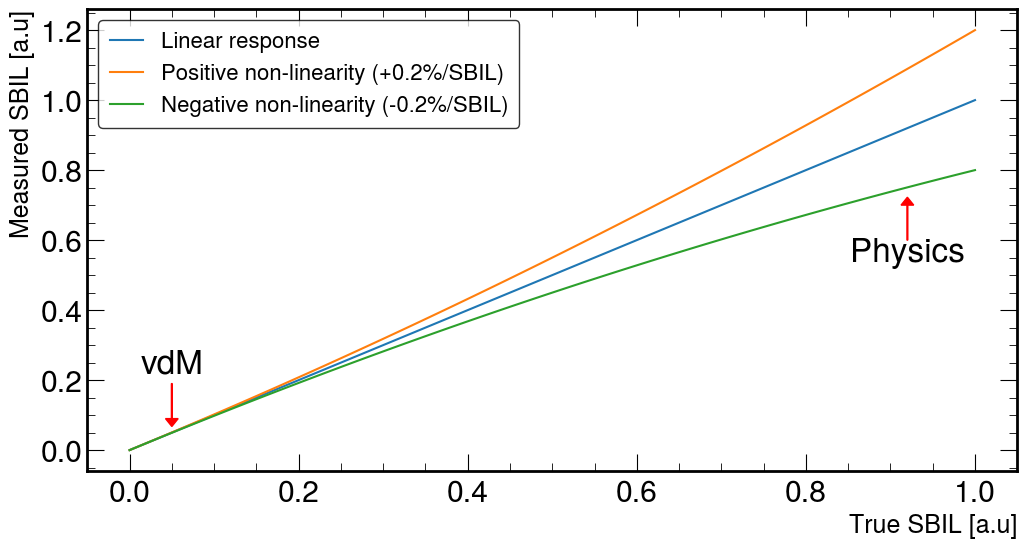

In [9]:
plt.figure(figsize=(12, 6))
plt.ylabel("Measured SBIL [a.u]", fontsize=18)
plt.xlabel("True SBIL [a.u]", fontsize=18)

x = np.linspace(0, 1, 100)
y_linear = x
y_positive = x + x**2 * (+0.2)
y_negative = x + x**2 * (-0.2)
plt.plot(x, y_linear, label="Linear response")
plt.plot(x, y_positive, label="Positive non-linearity (+0.2%/SBIL)")
plt.plot(x, y_negative, label="Negative non-linearity (-0.2%/SBIL)")
plt.text(0.05, 0.22, "vdM", ha="center", fontsize=24)
plt.arrow(0.05, 0.19, 0, -0.1, head_width=0.015, color="red")
plt.text(0.92, 0.54, "Physics", ha="center", fontsize=24)
plt.arrow(0.92, 0.6, 0, 0.1, head_width=0.015, color="red")



plt.legend(fontsize=16, edgecolor="black", frameon=True, facecolor="white")
plt.savefig("msc_latex_template/images/assets/non_linearity_diagram.pdf", bbox_inches = 'tight')
plt.show()

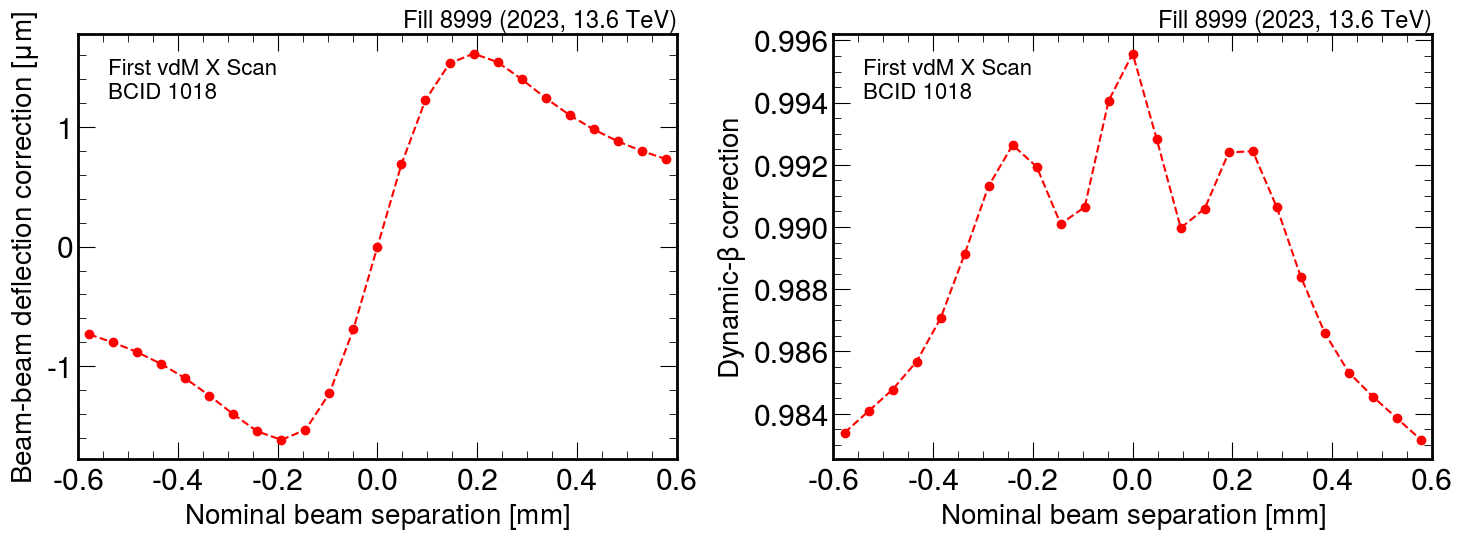

In [33]:
import json

with open("beam.json") as fp:
    data = json.load(fp)

plane_corr = []
scan = 1
bcid = 1018
plane = "X" if scan == 1 else "Y"
for sp in data[f"Scan_{scan}"]:
    plane_corr.append(sp[f"corr_{plane}coord"][str(bcid)] * 1000)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
hep.cms.label(exp="", llabel="", fontsize=18, rlabel="Fill 8999 (2023, 13.6 TeV)", ax=axs[0])
axs[0].text(0.05, 0.85, f"First vdM {plane} Scan\nBCID {bcid}", transform=axs[0].transAxes, fontsize=16, fontname='sans-serif')
seps = [
    -0.577758, -0.529611, -0.481465, -0.433318, -0.385172,
    -0.337025, -0.288879, -0.240732, -0.192586, -0.144439,
    -0.096293, -0.048146,      -0.0,  0.048146,  0.096293,
     0.144439,  0.192586,  0.240732,  0.288879,  0.337025,
     0.385172,  0.433318,  0.481465,  0.529611,  0.577758
]
axs[0].plot(seps, plane_corr, "--o", color="red", label="x plane")
axs[0].set_xlabel("Nominal beam separation [$mm$]", loc="center", fontsize=20)
axs[0].set_ylabel("Beam-beam deflection correction [$\mu m$]", loc="center", fontsize=20)
axs[0].set_xlim(-0.6, 0.6)
# plt.savefig("msc_latex_template/images/assets/beam_beam_correction.pdf", bbox_inches = 'tight')
# plt.show()

with open("dynamic.json") as fp:
    data = json.load(fp)

plane_corr = []
plane = "X" if scan == 1 else "Y"
for sp_val in data[f"Scan_{scan}_{plane}1"][str(bcid)]:
    plane_corr.append(sp_val[1])

hep.cms.label(exp="", llabel="", fontsize=18, rlabel="Fill 8999 (2023, 13.6 TeV)", ax=axs[1])
axs[1].text(0.05, 0.85, f"First vdM {plane} Scan\nBCID {bcid}", transform=axs[1].transAxes, fontsize=16, fontname='sans-serif')
seps = [
    -0.577758, -0.529611, -0.481465, -0.433318, -0.385172,
    -0.337025, -0.288879, -0.240732, -0.192586, -0.144439,
    -0.096293, -0.048146,      -0.0,  0.048146,  0.096293,
     0.144439,  0.192586,  0.240732,  0.288879,  0.337025,
     0.385172,  0.433318,  0.481465,  0.529611,  0.577758
]
axs[1].plot(seps, plane_corr, "--o", color="red", label="x plane")
axs[1].set_xlabel("Nominal beam separation [$mm$]", loc="center", fontsize=20)
axs[1].set_ylabel(r"Dynamic-$\beta$ correction", loc="center", fontsize=20)
axs[1].set_xlim(-0.6, 0.6)
plt.tight_layout()
plt.savefig("msc_latex_template/images/assets/beam_effects_correcions.pdf", bbox_inches = 'tight')
plt.show()

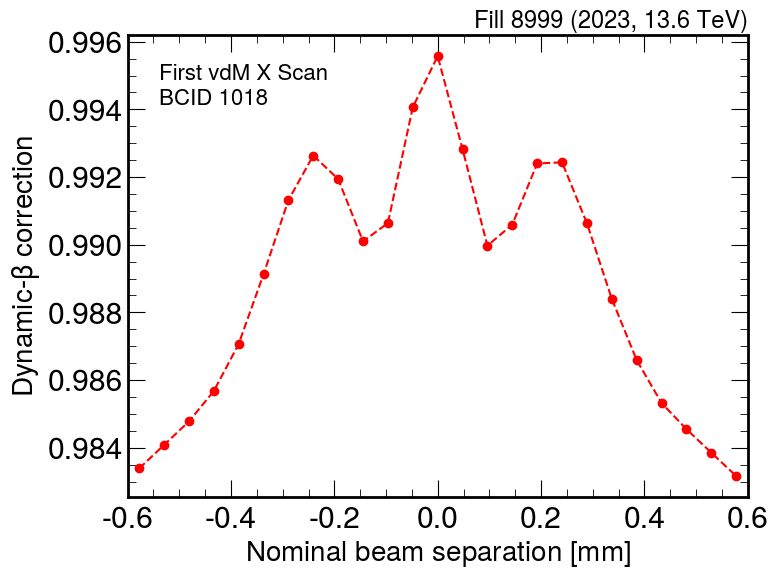

In [9]:
import json

with open("dynamic.json") as fp:
    data = json.load(fp)

plane_corr = []
plane = "X" if scan == 1 else "Y"
for sp_val in data[f"Scan_{scan}_{plane}1"][str(bcid)]:
    plane_corr.append(sp_val[1])

plt.figure(figsize=(8, 6))
hep.cms.label(exp="", llabel="", fontsize=18, rlabel="Fill 8999 (2023, 13.6 TeV)")
plt.text(0.05, 0.85, f"First vdM {plane} Scan\nBCID {bcid}", transform=plt.gca().transAxes, fontsize=16, fontname='sans-serif')
seps = [
    -0.577758, -0.529611, -0.481465, -0.433318, -0.385172,
    -0.337025, -0.288879, -0.240732, -0.192586, -0.144439,
    -0.096293, -0.048146,      -0.0,  0.048146,  0.096293,
     0.144439,  0.192586,  0.240732,  0.288879,  0.337025,
     0.385172,  0.433318,  0.481465,  0.529611,  0.577758
]
plt.plot(seps, plane_corr, "--o", color="red", label="x plane")
plt.xlabel("Nominal beam separation [$mm$]", loc="center", fontsize=20)
plt.ylabel(r"Dynamic-$\beta$ correction", loc="center", fontsize=20)
plt.xlim(-0.6, 0.6)
plt.savefig("msc_latex_template/images/assets/dynamic_beta_correction.pdf", bbox_inches = 'tight')
plt.show()

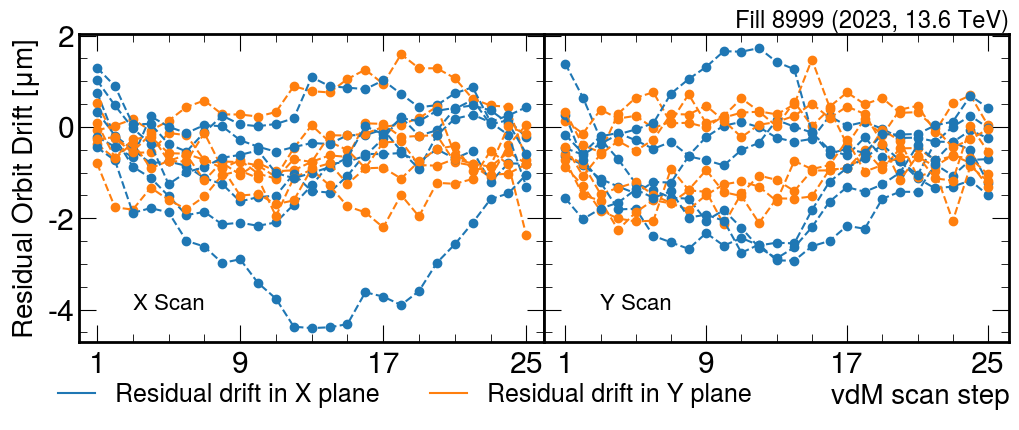

In [10]:
import matplotlib.pyplot as plt
import numpy as np

hep.style.use("CMS")

name_scan = {
    "vdm1": "8999_28Jun23_230143_28Jun23_232943",
    # "bi1" : "8999_29Jun23_004658_29Jun23_011220",
    # "bi2" : "8999_29Jun23_013851_29Jun23_020425",
    "vdm2": "8999_29Jun23_023227_29Jun23_025502",
    "vdm3": "8999_29Jun23_073830_29Jun23_080352",«b
    "vdm4": "8999_29Jun23_092415_29Jun23_094738",
    "vdm5": "8999_29Jun23_110004_29Jun23_112226",
    "vdm6": "8999_29Jun23_123257_29Jun23_125514"
}

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.subplots_adjust(wspace=0)

rod = pd.read_csv("rod.csv")
rod["correction_x"] -= rod["correction_x"].iloc[0]
rod["correction_y"] -= rod["correction_y"].iloc[0]
steps = list(range(1, 26))

for i, scan in enumerate([1, 2]):
    plane = "X" if scan == 1 else "Y"
    for j, (name, folder) in enumerate(name_scan.items()):
        scan_rod = rod.query(f"scan_name == '{folder}' and plane == {scan}")
        axs[i].plot(steps, scan_rod["correction_x"], "--o", color="#1f77b4")
        axs[i].plot(steps, scan_rod["correction_y"], "--o", color="#ff7f0e")

hep.cms.label(exp="", llabel="", fontsize=18, rlabel="Fill 8999 (2023, 13.6 TeV)", ax=axs[1])
axs[0].set_ylabel("Residual Orbit Drift [$\mu m$]", loc="center", fontsize=20)
axs[1].set_xlabel("vdM scan step", fontsize=20)
axs[0].text(5, -4, "X Scan", fontname='sans-serif', fontsize=16, horizontalalignment="center")
axs[1].text(5, -4, "Y Scan", fontname='sans-serif', fontsize=16, horizontalalignment="center")
axs[0].set_xticks(range(1, 26, 8))
axs[1].set_xticks(range(1, 26, 8))
axs[0].plot([-1000], [-1000], color="#1f77b4", label="Residual drift in X plane")
axs[0].plot([-1000], [-1000], color="#ff7f0e", label="Residual drift in Y plane")
axs[0].set_ylim((-4.71213656115783, 2.0312824712152593))
axs[0].set_xlim((0, 26))
axs[0].legend(loc="upper left", bbox_to_anchor=(-0.1, -0.05), ncol=2, fontsize=18)
plt.savefig("msc_latex_template/images/assets/residual_orbit_drift_correction.pdf", bbox_inches="tight")
plt.show()

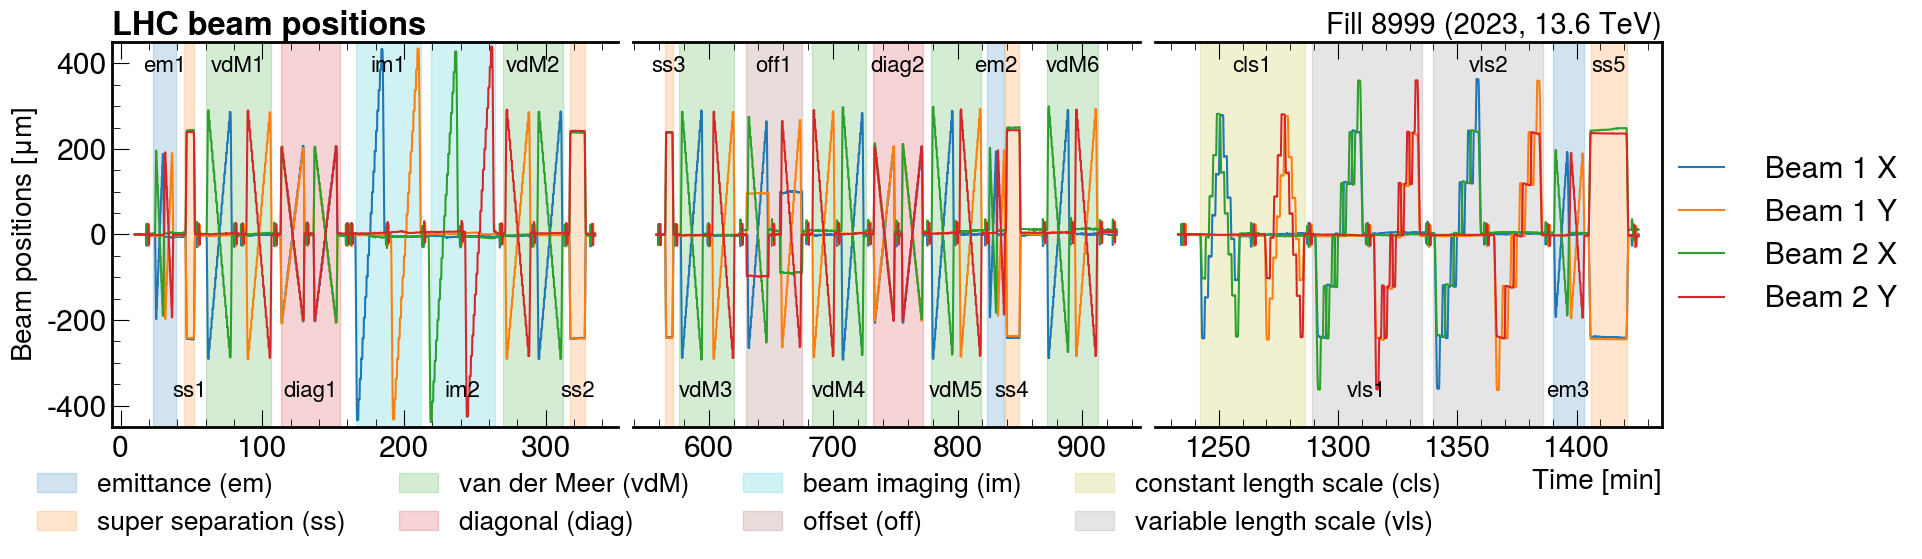

In [11]:
beam_pos = pd.read_csv("analysis_8999_full_bpm.csv")[
    ["Timestamp", "B1H_DOROS_position", "B1V_DOROS_position", "B2H_DOROS_position", "B2V_DOROS_position"]
].rename(columns={
    "B1H_DOROS_position": "  Beam 1 X",
    "B1V_DOROS_position": "  Beam 1 Y",
    "B2H_DOROS_position": "  Beam 2 X",
    "B2V_DOROS_position": "  Beam 2 Y"
})

beam_pos["Timestamp"] = pd.to_datetime(beam_pos["Timestamp"])
beam_pos["Timestamp"] -= beam_pos["Timestamp"].iloc[0]
beam_pos["Timestamp"] = beam_pos["Timestamp"].apply(lambda x: x.seconds / 60)

lims = [
    [10,   335],
    [558, 928],
    [1233, 1426]
]

fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
fig.subplots_adjust(wspace=0.03)
for i, ax in enumerate(axs):
    pos = beam_pos.query(f"Timestamp >= {lims[i][0]} and Timestamp <= {lims[i][1]}")
    for col in ["  Beam 1 X", "  Beam 1 Y", "  Beam 2 X", "  Beam 2 Y"]:
        ax.plot(pos["Timestamp"], pos[col], label=col)

# axs[0]: Remove right axis bar and all ticks
axs[0].spines['right'].set_visible(False)
axs[0].yaxis.set_ticks_position('left')
axs[0].tick_params(right=False)

# axs[1]: Remove left and right axis bar and all ticks
axs[1].spines['left'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].yaxis.set_ticks_position('none')
axs[1].tick_params(left=False, right=False)

# axs[2]: Remove left axis bar and all ticks
axs[2].spines['left'].set_visible(False)
axs[2].yaxis.set_ticks_position('none')
axs[2].tick_params(left=False)

texts = [
    [
        {"alias": "em1", "name": "emittance (em)", "color": "#1f77b4", "time": [23, 39]},
        {"alias": "ss1", "name": "super separation (ss)", "color": "#ff7f0e", "time": [45, 52]},
        {"alias": "vdM1", "name": "van der Meer (vdM)", "color": "#2ca02c", "time": [60, 106]},
        {"alias": "diag1", "name": "diagonal (diag)", "color": "#d62728", "time": [113, 155]},
        {"alias": "im1", "name": "beam imaging (im)", "color": "#17becf", "time": [166, 212]},
        {"alias": "im2", "name": "beam imaging (im)", "color": "#17becf", "time": [219, 264]},
        {"alias": "vdM2", "name": "van der Meer (vdM)", "color": "#2ca02c", "time": [270, 312]},
        {"alias": "ss2", "name": "super separation (ss)", "color": "#ff7f0e", "time": [317, 328]},
    ],
    [
        {"alias": "ss3", "name": "super separation (ss)", "color": "#ff7f0e", "time": [565, 571]},
        {"alias": "vdM3", "name": "van der Meer (vdM)", "color": "#2ca02c", "time": [576, 620]},
        {"alias": "off1", "name": "offset (off)", "color": "#8c564b", "time": [630, 675]},
        {"alias": "vdM4", "name": "van der Meer (vdM)", "color": "#2ca02c", "time": [683, 726]},
        {"alias": "diag2", "name": "diagonal (diag)", "color": "#d62728", "time": [732, 772]},
        {"alias": "vdM5", "name": "van der Meer (vdM)", "color": "#2ca02c", "time": [779, 819]},
        {"alias": "em2", "name": "emittance (em)", "color": "#1f77b4", "time": [824, 837]},
        {"alias": "ss4", "name": "super separation (ss)", "color": "#ff7f0e", "time": [838, 849]},
        {"alias": "vdM6", "name": "van der Meer (vdM)", "color": "#2ca02c", "time": [872, 913]},
    ],
    [
        {"alias": "cls1", "name": "constant length scale (cls)", "color": "#bcbd22", "time": [1242, 1286]},
        {"alias": "vls1", "name": "variable length scale (vls)", "color": "#7f7f7f", "time": [1289, 1335]},
        {"alias": "vls2", "name": "variable length scale (vls)", "color": "#7f7f7f", "time": [1340, 1386]},
        {"alias": "em3", "name": "emittance (em)", "color": "#1f77b4", "time": [1390, 1403]},
        {"alias": "ss5", "name": "super separation (ss)", "color": "#ff7f0e", "time": [1406, 1421]},
    ],
]

# colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
for i, txts in enumerate(texts):
    for j, txt in enumerate(txts):
        x = sum(txt["time"]) / 2
        y = 380 if j % 2 == 0 else -380
        axs[i].fill_betweenx([-450, 450], *txt["time"], color=txt["color"], alpha=0.2, label=txt["name"])
        axs[i].text(x, y, txt["alias"], fontname='sans-serif', fontsize=16, horizontalalignment="center", weight="normal")

plt.ylim(-450, 450)
hep.cms.label(exp="LHC beam positions", llabel="", fontsize=18, rlabel="", ax=axs[0])
hep.cms.label(exp="", llabel="", fontsize=22, rlabel="Fill 8999 (2023, 13.6 TeV)", ax=axs[-1])
axs[0].set_ylabel("Beam positions [$\mu m$]", loc="center", fontsize=20)
axs[-1].set_xlabel("Time [min]", fontsize=20)
all_handles = []
all_labels  = []
for ax in axs:
    handles, labels = ax.get_legend_handles_labels()
    all_handles.extend(handles)
    all_labels.extend(labels)
beam_labels = pd.DataFrame(list(zip(all_handles, all_labels)), columns=["handles", "labels"]).drop_duplicates(subset="labels").iloc[0:4]
shade_labels = pd.DataFrame(list(zip(all_handles, all_labels)), columns=["handles", "labels"]).drop_duplicates(subset="labels").iloc[4:]
axs[-1].legend(beam_labels["handles"].values, beam_labels["labels"].values, loc='center', bbox_to_anchor=(1.25, 0.5))
axs[0].legend(shade_labels["handles"].values, shade_labels["labels"].values, loc='upper left', bbox_to_anchor=(-0.2, -0.05), ncols=4, fontsize=19)
plt.savefig("msc_latex_template/images/assets/vdm_fill_program.pdf", bbox_inches = 'tight')
plt.show()

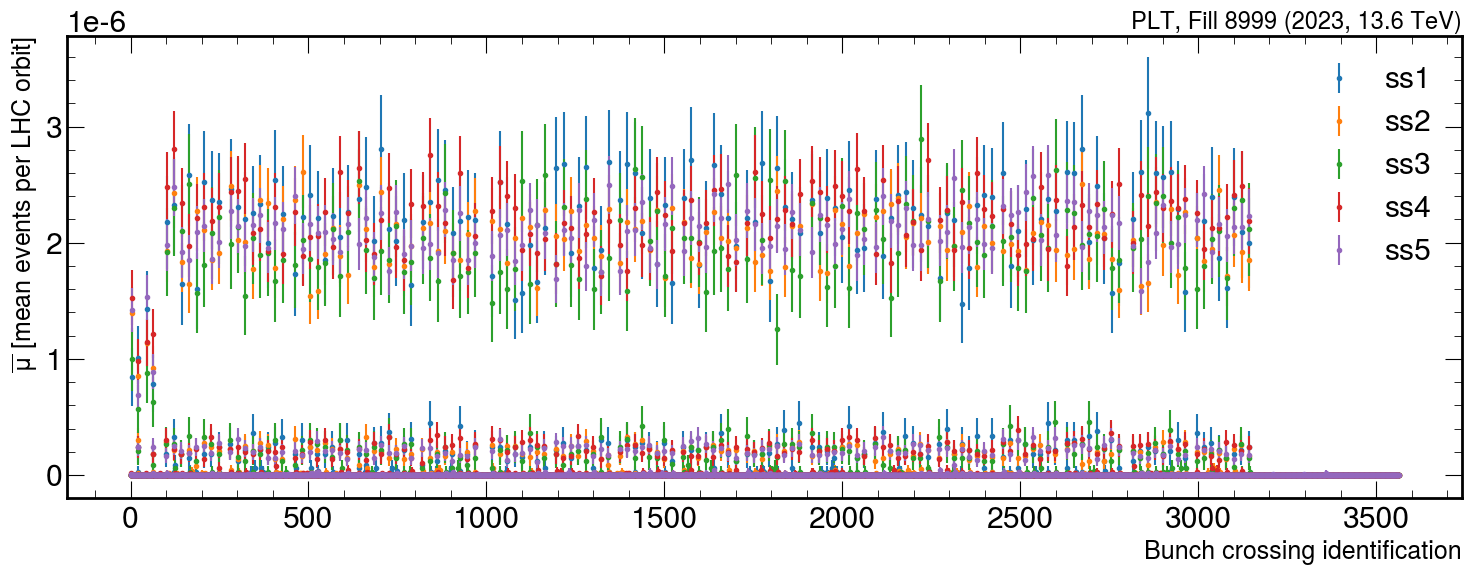

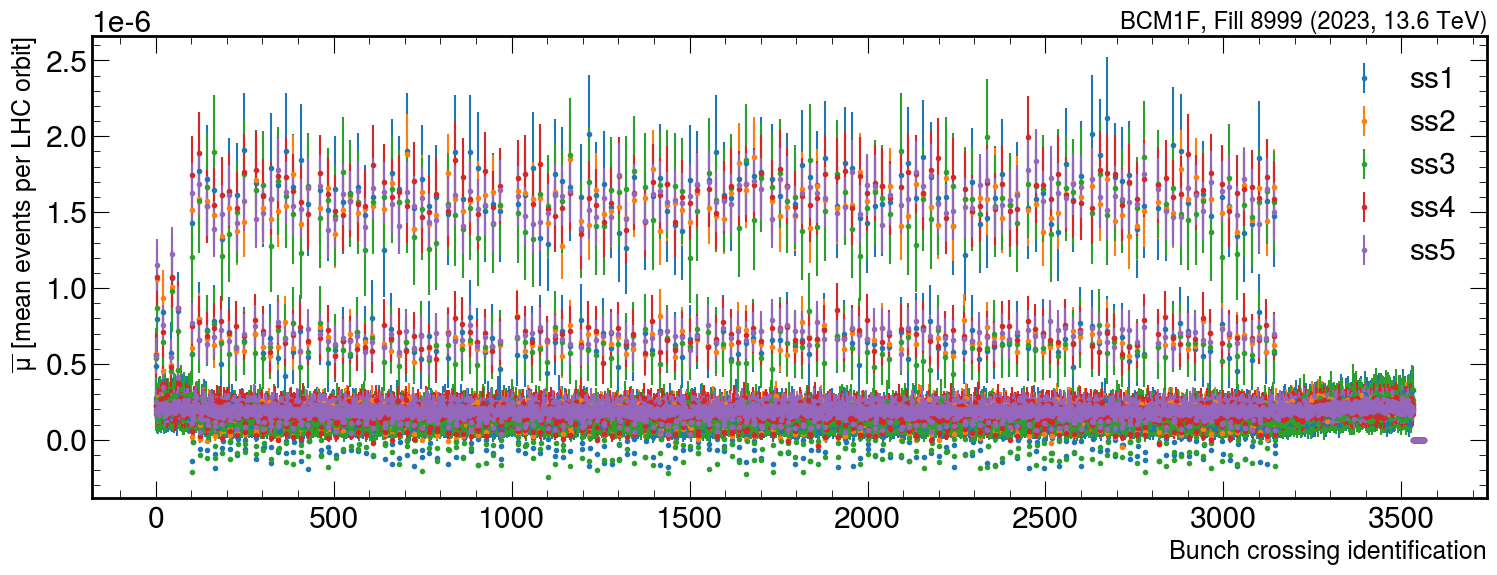

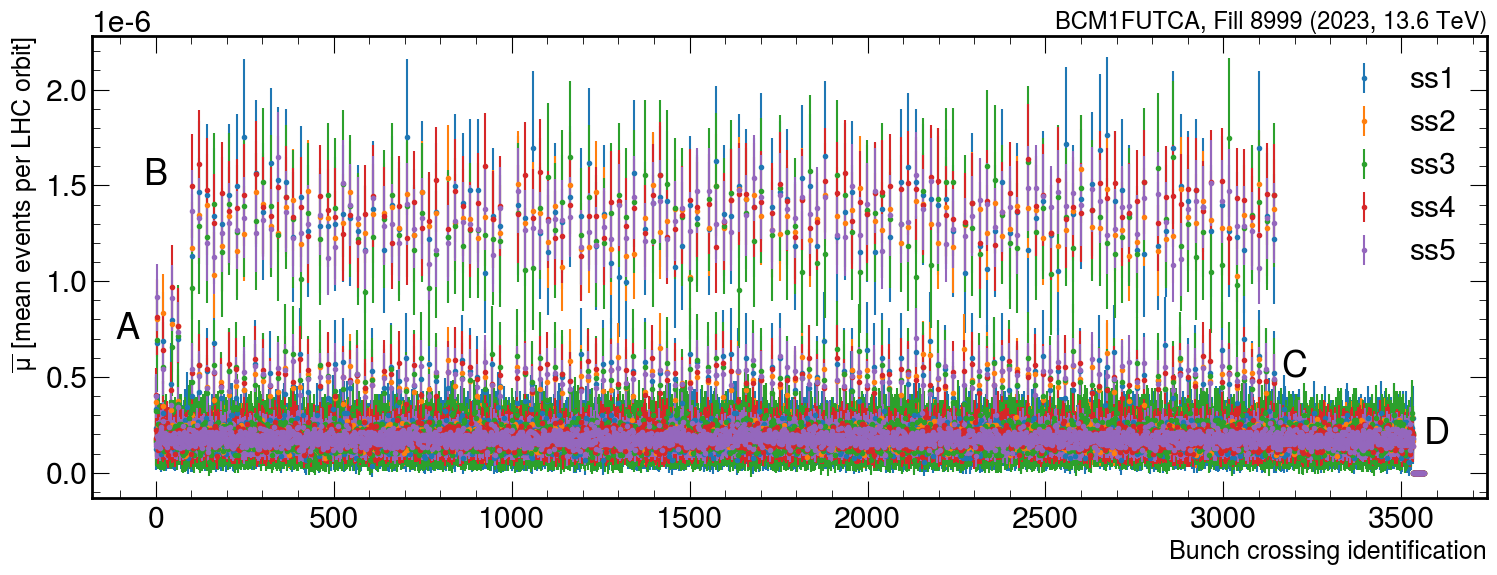

In [6]:
ss_scans = {
    "ss1": ("8999_230628204539_230628205243.hd5", 1687985202, 1687985500),
    "ss2": ("8999_230629011628_230629012832.hd5", 1688001451, 1688002050),
    "ss3": ("8999_230629052445_230629053148.hd5", 1688016348, 1688016647),
    "ss4": ("8999_230629095837_230629101041.hd5", 1688032779, 1688033378),
    "ss5": ("8999_230629192448_230629194151.hd5", 1688066751, 1688067650),
}
det2table = {
    "PLT": "scan5_pltlumizero",
    "BCM1F": "scan5_bcm1flumi",
    "BCM1FUTCA": "scan5_bcm1futcalumi",
}

base = Path("/home/fabiocfabini/Work/BRIL/mnts/brildata/vdmdata23/8999/")

for det, table in det2table.items():
    plt.figure(figsize=(18, 6))
    for scan, (file, start, end) in ss_scans.items():
        ss = hd5_to_pandas(base / file, table)

        ss = ss[(ss["timestampsec"] > start) & (ss["timestampsec"] < end)]

        avg_mu_per_bcid = np.stack(ss.bxraw).mean(axis=0)
        err_mu_per_bcid = (avg_mu_per_bcid * (1 - avg_mu_per_bcid)) / (16 * 4096 * len(ss))
        err_mu_per_bcid[err_mu_per_bcid < 0] = 0
        err_mu_per_bcid = np.sqrt(err_mu_per_bcid)

        plt.errorbar(list(range(3564)), avg_mu_per_bcid, yerr=err_mu_per_bcid, fmt="o", markersize=3, label=f"{scan}")

    if det == "BCM1FUTCA":
        plt.text(0, 1.5*1e-6, "B", horizontalalignment="center")
        plt.text(-80, 0.7*1e-6, "A", horizontalalignment="center")
        plt.text(3200, 0.5*1e-6, "C", horizontalalignment="center")
        plt.text(3600, 0.15*1e-6, "D", horizontalalignment="center")

    hep.cms.label(exp="", llabel="", rlabel=f"{det}, Fill 8999 (2023, 13.6 TeV)", fontsize=18)
    plt.xlabel("Bunch crossing identification", fontsize=18)
    plt.ylabel("$\overline{\mu}$ [mean events per LHC orbit]", fontsize=18)
    plt.legend()
    plt.savefig(f"msc_latex_template/images/assets/8999SuperSeparation_{det}.pdf", bbox_inches="tight")
    plt.show()
    plt.close()

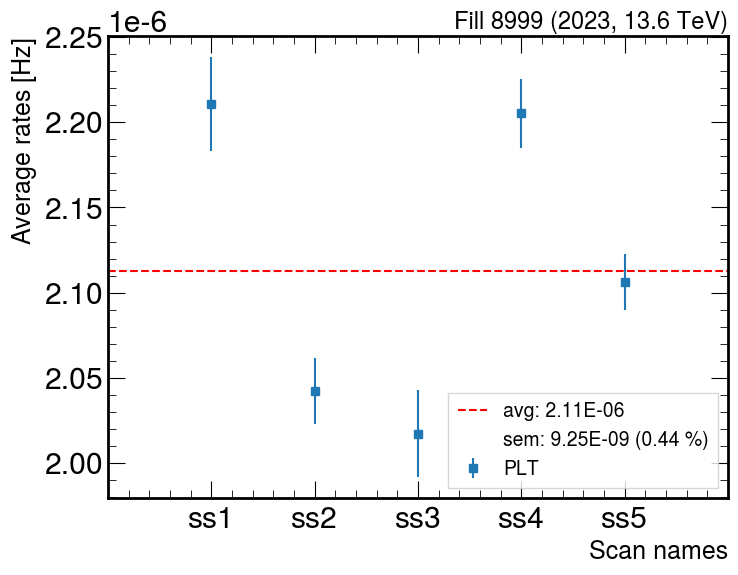

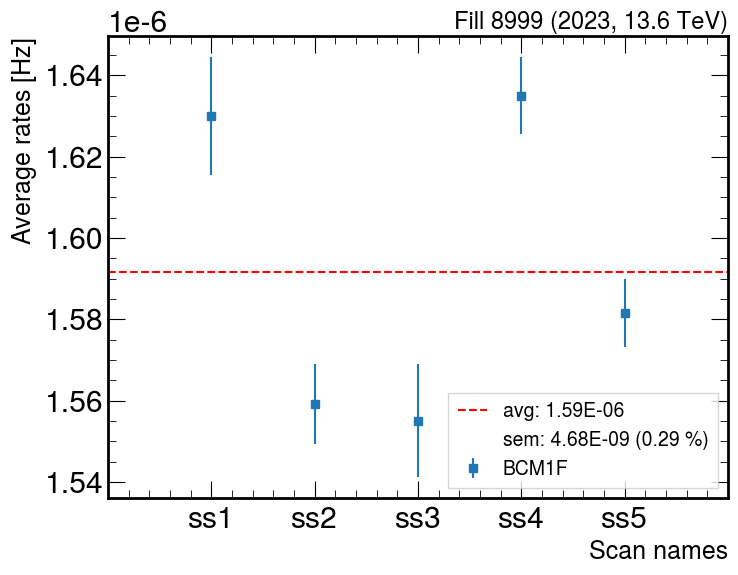

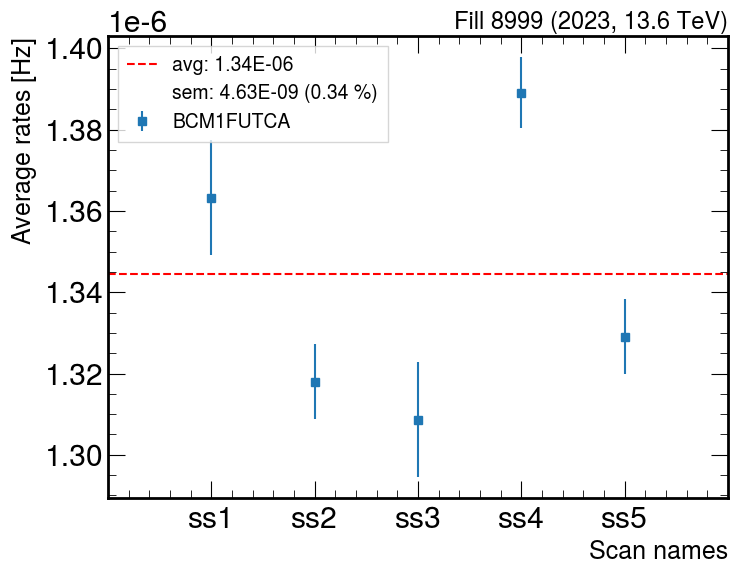

In [6]:
ss_scans = {
    "ss1": ("8999_230628204539_230628205243.hd5", 1687985202, 1687985500),
    "ss2": ("8999_230629011628_230629012832.hd5", 1688001451, 1688002050),
    "ss3": ("8999_230629052445_230629053148.hd5", 1688016348, 1688016647),
    "ss4": ("8999_230629095837_230629101041.hd5", 1688032779, 1688033378),
    "ss5": ("8999_230629192448_230629194151.hd5", 1688066751, 1688067650),
}
det2table = {
    "PLT": ("scan5_pltlumizero", 2.112622E-6, 9.25e-9),
    "BCM1F": ("scan5_bcm1flumi", 1.591679E-6, 4.68e-9),
    "BCM1FUTCA": ("scan5_bcm1futcalumi", 1.344486E-6, 4.63e-9),
}

base = Path("/home/fabiocfabini/Work/BRIL/brildata/vdmdata23/8999/")

for det, (table, m, e) in det2table.items():
    plt.figure(figsize=(8, 6))
    avgs = []
    stds = []
    for scan, (file, start, end) in ss_scans.items():
        ss = hd5_to_pandas(base / file, table)
        beam = hd5_to_pandas(base / file, "scan5_beam")
        bxmask = beam.collidable.iloc[10]

        ss = ss[(ss["timestampsec"] > start) & (ss["timestampsec"] < end)]

        avg_mu_per_bcid = np.stack(ss.bxraw).mean(axis=0)
        avg_mu_per_bcid = avg_mu_per_bcid[bxmask == 1]

        avgs.append(np.mean(avg_mu_per_bcid))
        stds.append(pd.Series(avg_mu_per_bcid).sem())

    avg = m
    err = e

    plt.axhline(avg, linestyle="dashed", label=f"avg: {avg:.2E}", color="red")
    plt.fill_between(range(-1, 6), avg-err, avg+err, label=f"sem: {err:.2E} ({err / avg * 100:.2f} %)", color="orange", alpha=0)
    plt.errorbar(range(5), avgs, yerr=stds, fmt="s", label=det)
    plt.xticks(ticks=range(5), labels=["ss1", "ss2", "ss3", "ss4", "ss5"])

    hep.cms.label(exp="", llabel="", rlabel="Fill 8999 (2023, 13.6 TeV)", fontsize=18)
    plt.xlabel("Scan names", fontsize=18)
    plt.ylabel("Average rates [$Hz$] ", fontsize=18)
    plt.xlim(-1, 5)
    plt.legend(frameon=True, fancybox=False, fontsize=14)
    plt.show()
    plt.close()

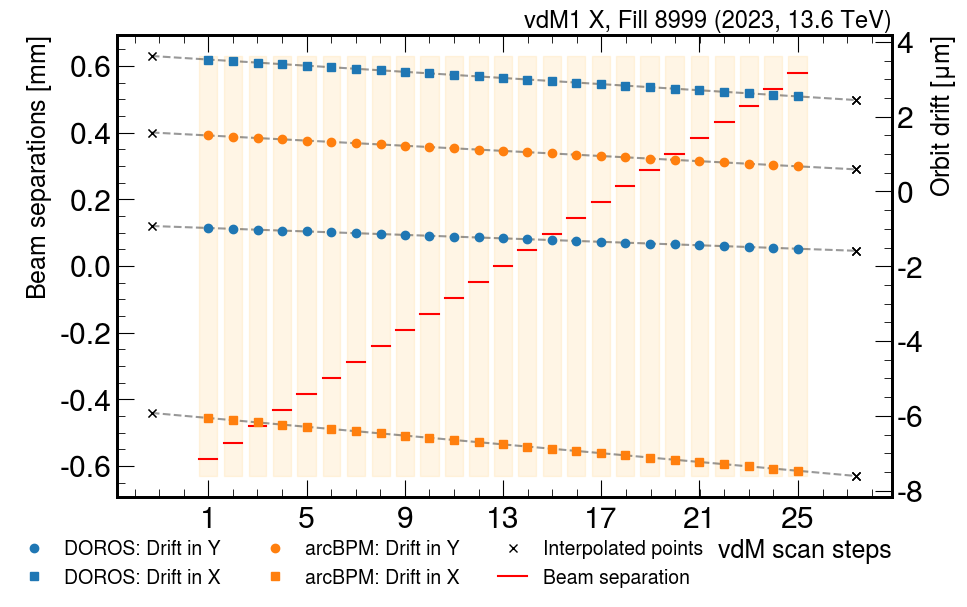

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import mplhep as hep
import tables as tb
from pathlib import Path
from vdmtools.io import hd5_to_pandas
from tqdm import tqdm
import json
import datetime
hep.style.use("CMS")

with open("scan.json") as fp:
    scan = json.load(fp)

with open("arcBPMLOD.json") as fp:
    arc_lod = json.load(fp)

with open("dorosBPMLOD.json") as fp:
    doros_lod = json.load(fp)

lods = {
    "arcBPM": arc_lod,
    "DOROS": doros_lod,
}

scan_df = pd.DataFrame(
    scan["Scan_1"],
    columns=[
        "Number", "PlaneNumber", "Step",
        "Start_sec", "End_sec", "Rsep",
        "Xsep", "Ysep", "Start_ls", "End_ls"
    ]
)

fig = plt.figure(figsize=(10,6))
ax = fig.gca()
hep.cms.label(exp="", llabel="", rlabel="vdM1 X, Fill 8999 (2023, 13.6 TeV)", fontsize=18)

middle_times = []
for i, row in scan_df.iterrows():
    ax.plot([row["Start_sec"], row["End_sec"]], [row["Rsep"], row["Rsep"]], color="red", label="Beam separation" if i == 0 else "")
    ax.fill_betweenx([-0.63, 0.63], row["Start_sec"], row["End_sec"], color="orange", alpha=0.1)
    middle_times.append((row["Start_sec"] + row["End_sec"]) / 2)
ax.set_xticks(ticks=middle_times[0:-1:4] + [middle_times[-1]], labels=list(scan_df["Step"][0:-1:4]) + [25])
ax.set_ylabel("Beam separations [$mm$]", fontsize=18)
ax.set_xlabel("vdM scan steps", fontsize=18)

axt = ax.twinx()
axt.set_ylabel("Orbit drift [$\mu m$]", fontsize=18)

for i, (bpm, meas) in enumerate(lods.items()):
    color = "#1f77b4" if i != 0 else "#ff7f0e"

    times = np.array(meas["TimeWindows"][2])
    odx = np.array(meas["OrbitDrifts_X"][2]) - meas["OrbitDrifts_X"][0][0]
    ody = np.array(meas["OrbitDrifts_Y"][2]) - meas["OrbitDrifts_Y"][0][0]

    odx_lerp = np.interp(middle_times, times, odx)
    ody_lerp = np.interp(middle_times, times, ody)

    axt.plot(times, odx, "x", color="black", label="Interpolated points" if i == 0 else "")
    axt.plot(times, odx, "--x", color="black", alpha=0.4)
    axt.plot(times, ody, "x", color="black")
    axt.plot(times, ody, "--x", color="black", alpha=0.4)
    axt.plot(middle_times, odx_lerp, "s", color=color, label=f"{bpm}: Drift in X")
    axt.plot(middle_times, ody_lerp, "o", color=color, label=f"{bpm}: Drift in Y")


handles, labels = ax.get_legend_handles_labels()
handles_t, labels_t = axt.get_legend_handles_labels()
handles.extend(handles_t)
labels.extend(labels_t)
axt.legend(handles[::-1], labels[::-1], fontsize=14, loc="upper left", bbox_to_anchor=(-0.15, -0.05), ncols=3)

plt.savefig("msc_latex_template/images/assets/linear_orbit_drift_vdm1x.pdf", bbox_inches="tight")
plt.show()

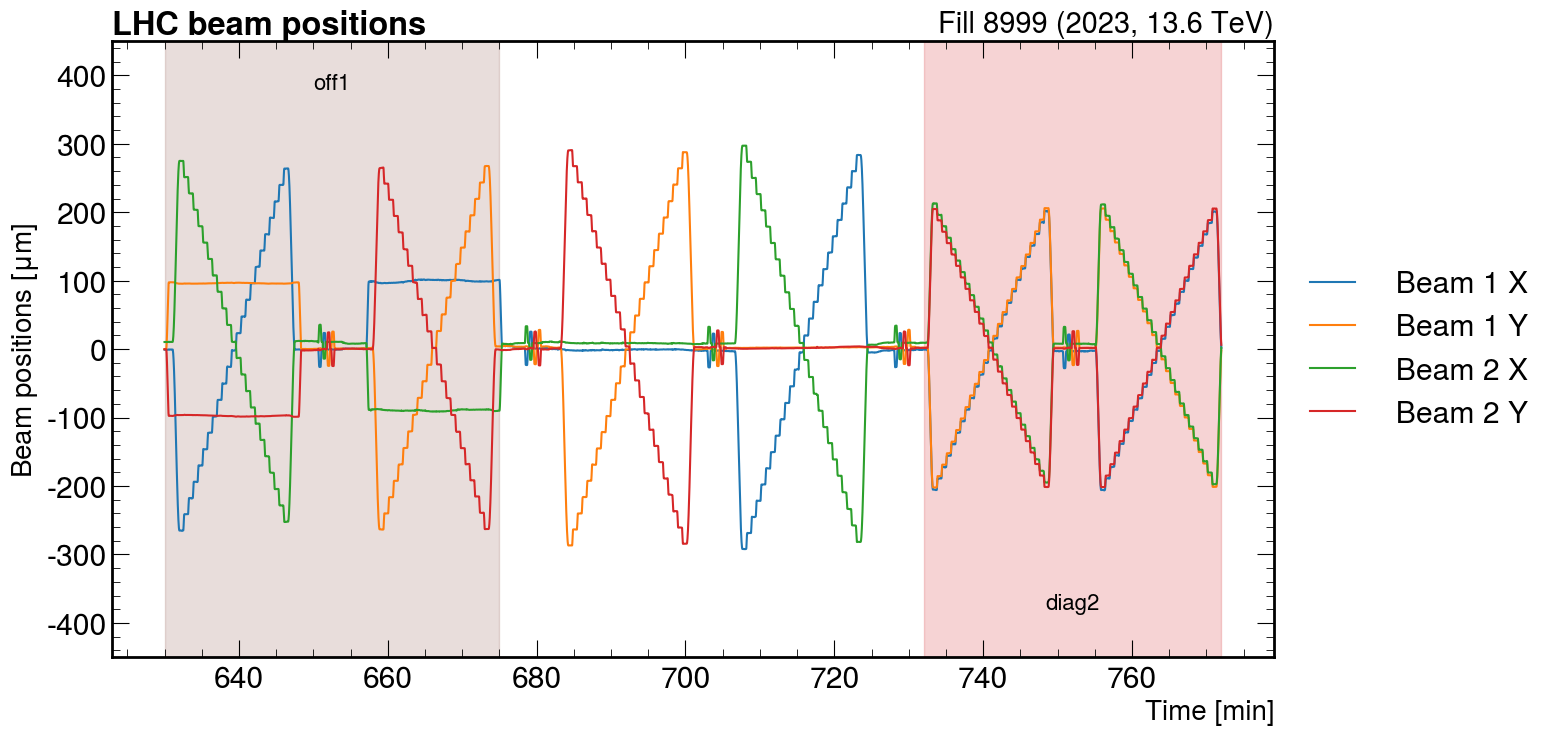

In [8]:
beam_pos = pd.read_csv("analysis_8999_full_bpm.csv")[
    ["Timestamp", "B1H_DOROS_position", "B1V_DOROS_position", "B2H_DOROS_position", "B2V_DOROS_position"]
].rename(columns={
    "B1H_DOROS_position": "  Beam 1 X",
    "B1V_DOROS_position": "  Beam 1 Y",
    "B2H_DOROS_position": "  Beam 2 X",
    "B2V_DOROS_position": "  Beam 2 Y"
})

beam_pos["Timestamp"] = pd.to_datetime(beam_pos["Timestamp"])
beam_pos["Timestamp"] -= beam_pos["Timestamp"].iloc[0]
beam_pos["Timestamp"] = beam_pos["Timestamp"].apply(lambda x: x.seconds / 60)

lims = [
    # [10,   335],
    [630, 772],
    # [1240, 1335]
]

fig, axs = plt.subplots(1, 1, figsize=(15, 8), sharey=True)
axs = [axs]
fig.subplots_adjust(wspace=0.03)
for i, ax in enumerate(axs):
    pos = beam_pos.query(f"Timestamp >= {lims[i][0]} and Timestamp <= {lims[i][1]}")
    for col in ["  Beam 1 X", "  Beam 1 Y", "  Beam 2 X", "  Beam 2 Y"]:
        ax.plot(pos["Timestamp"], pos[col], label=col)

# # axs[0]: Remove right axis bar and all ticks
# axs[0].spines['right'].set_visible(False)
# axs[0].yaxis.set_ticks_position('left')
# axs[0].tick_params(right=False)

# # axs[1]: Remove left and right axis bar and all ticks
# axs[1].spines['left'].set_visible(False)
# axs[1].spines['right'].set_visible(False)
# axs[1].yaxis.set_ticks_position('none')
# axs[1].tick_params(left=False, right=False)

# # axs[2]: Remove left axis bar and all ticks
# axs[2].spines['left'].set_visible(False)
# axs[2].yaxis.set_ticks_position('none')
# axs[2].tick_params(left=False)

texts = [
    # [
    #     {"alias": "em1", "name": "emittance (em)", "color": "#1f77b4", "time": [23, 39]},
    #     {"alias": "ss1", "name": "super separation (ss)", "color": "#ff7f0e", "time": [45, 52]},
    #     {"alias": "vdM1", "name": "van der Meer (vdM)", "color": "#2ca02c", "time": [60, 106]},
    #     {"alias": "diag1", "name": "diagonal (diag)", "color": "#d62728", "time": [113, 155]},
    #     {"alias": "im1", "name": "beam imaging (im)", "color": "#17becf", "time": [166, 212]},
    #     {"alias": "im2", "name": "beam imaging (im)", "color": "#17becf", "time": [219, 264]},
    #     {"alias": "vdM2", "name": "van der Meer (vdM)", "color": "#2ca02c", "time": [270, 312]},
    #     {"alias": "ss2", "name": "super separation (ss)", "color": "#ff7f0e", "time": [317, 328]},
    # ],
    [
        # {"alias": "ss3", "name": "super separation (ss)", "color": "#ff7f0e", "time": [565, 571]},
        # {"alias": "vdM3", "name": "van der Meer (vdM)", "color": "#2ca02c", "time": [576, 620]},
        {"alias": "off1", "name": "offset (off)", "color": "#8c564b", "time": [630, 675]},
        # {"alias": "vdM4", "name": "van der Meer (vdM)", "color": "#2ca02c", "time": [683, 726]},
        {"alias": "diag2", "name": "diagonal (diag)", "color": "#d62728", "time": [732, 772]},
        # {"alias": "vdM5", "name": "van der Meer (vdM)", "color": "#2ca02c", "time": [779, 819]},
        # {"alias": "em2", "name": "emittance (em)", "color": "#1f77b4", "time": [824, 837]},
        # {"alias": "ss4", "name": "super separation (ss)", "color": "#ff7f0e", "time": [838, 849]},
        # {"alias": "vdM6", "name": "van der Meer (vdM)", "color": "#2ca02c", "time": [872, 913]},
    ],
    # [
    #     {"alias": "cls1", "name": "constant length scale (cls)", "color": "#bcbd22", "time": [1242, 1286]},
    #     {"alias": "vls1", "name": "variable length scale (vls)", "color": "#7f7f7f", "time": [1289, 1335]},
    #     {"alias": "vls2", "name": "variable length scale (vls)", "color": "#7f7f7f", "time": [1340, 1386]},
    #     {"alias": "em3", "name": "emittance (em)", "color": "#1f77b4", "time": [1390, 1403]},
    #     {"alias": "ss5", "name": "super separation (ss)", "color": "#ff7f0e", "time": [1406, 1421]},
    # ],
]

# colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
for i, txts in enumerate(texts):
    for j, txt in enumerate(txts):
        x = sum(txt["time"]) / 2
        y = 380 if j % 2 == 0 else -380
        axs[i].fill_betweenx([-450, 450], *txt["time"], color=txt["color"], alpha=0.2)
        axs[i].text(x, y, txt["alias"], fontname='sans-serif', fontsize=16, horizontalalignment="center", weight="normal")

plt.ylim(-450, 450)
hep.cms.label(exp="LHC beam positions", llabel="", fontsize=18, rlabel="", ax=axs[0])
hep.cms.label(exp="", llabel="", fontsize=22, rlabel="Fill 8999 (2023, 13.6 TeV)", ax=axs[-1])
axs[0].set_ylabel("Beam positions [$\mu m$]", loc="center", fontsize=20)
axs[-1].set_xlabel("Time [min]", fontsize=20)
all_handles = []
all_labels  = []
for ax in axs:
    handles, labels = ax.get_legend_handles_labels()
    all_handles.extend(handles)
    all_labels.extend(labels)
beam_labels = pd.DataFrame(list(zip(all_handles, all_labels)), columns=["handles", "labels"]).drop_duplicates(subset="labels").iloc[0:4]
shade_labels = pd.DataFrame(list(zip(all_handles, all_labels)), columns=["handles", "labels"]).drop_duplicates(subset="labels").iloc[4:]
axs[-1].legend(beam_labels["handles"].values, beam_labels["labels"].values, loc='center left', bbox_to_anchor=(1.005, 0.5))
# axs[0].legend(shade_labels["handles"].values, shade_labels["labels"].values, loc='upper left', bbox_to_anchor=(-0.2, -0.05), ncols=4, fontsize=19)
plt.savefig("msc_latex_template/images/assets/off_axis_scans.pdf", bbox_inches = 'tight')
plt.show()

In [56]:
df = pd.read_csv("output_profile_end.out", names=["name", "time"])

# markers = (df["name"] == "main").cumsum()
# markers -= markers - np.roll(markers, 1)
# markers.iloc[0] = 0

# avg_total = []
# avg_rate = []
# avg_beam = []
# avg_scan = []
# avg_other = []
# for marker, group in df.groupby(markers):
#     avg_total.append(group[group["name"] == "main"]["time"].item())
#     avg_rate.append(group[group["name"] == "doMakeRateFile"]["time"].item())
#     avg_beam.append(group[group["name"] == "make_beam_current_file"]["time"].item())
#     avg_scan.append(group[group["name"] == "make_scanfile"]["time"].item())
#     avg_other.append(group[group["name"] == "drive_vdm"]["time"].sum())

# avg_total = np.mean(avg_total)
# avg_rate = np.mean(avg_rate)
# avg_beam = np.mean(avg_beam)
# avg_scan = np.mean(avg_scan)
# avg_other = np.mean(avg_other)

n = df[df["name"] == "main"].__len__()
avg_total = df[df["name"] == "main"]["time"].mean()
avg_rate = df[df["name"] == "doMakeRateFile"]["time"].mean()
avg_beam = df[df["name"] == "make_beam_current_file"]["time"].mean()
avg_scan = df[df["name"] == "make_scanfile"]["time"].mean()
std_total = df[df["name"] == "main"]["time"].std()
std_rate = df[df["name"] == "doMakeRateFile"]["time"].std()
std_beam = df[df["name"] == "make_beam_current_file"]["time"].std()
std_scan = df[df["name"] == "make_scanfile"]["time"].std()
avg_other = avg_total - avg_rate - avg_beam - avg_scan
std_other = np.sqrt(std_total**2 + std_rate**2 + std_beam**2 + std_scan**2)

print(f"Total time: {avg_total:.2f}")
print("| Procedure | Time [s] | % of total program |")
print("|:---------:|:----:|:-------------------:|")
print(f"| Scan Parser | {avg_scan:.2f} $\pm$ {std_scan:.2f} | {avg_scan / avg_total * 100:.2f} |")
print(f"| Beam Analyser | {avg_beam:.2f} $\pm$ {std_beam:.2f} | {avg_beam / avg_total * 100:.2f} |")
print(f"| Rate Analyser | {avg_rate:.2f} $\pm$ {std_rate:.2f} | {avg_rate / avg_total * 100:.2f} |")
# print(f"| Stage II + III | {avg_other:.2f} $\pm$ {0.57:.2f} | {avg_other / avg_total * 100:.2f} |")
print(f"| Stage II + III | {avg_other:.2f} $\pm$ {std_other:.2f} | {avg_other / avg_total * 100:.2f} |")

Total time: 32.06
| Procedure | Time [s] | % of total program |
|:---------:|:----:|:-------------------:|
| Scan Parser | 0.35 $\pm$ 0.02 | 1.08 |
| Beam Analyser | 0.90 $\pm$ 0.11 | 2.80 |
| Rate Analyser | 0.36 $\pm$ 0.02 | 1.11 |
| Stage II + III | 30.46 $\pm$ 0.54 | 95.01 |


| Procedure | Time [s] | % of total program |
|:---------:|:----:|:-------------------:|
| Scan Parser | 0.35 $\pm$ 0.02 | 1.08 |
| Beam Analyser | 0.90 $\pm$ 0.11 | 2.80 |
| Rate Analyser | 0.36 $\pm$ 0.02 | 1.11 |
| Stage II + III | 30.46 $\pm$ 0.54 | 95.01 |